# Session 5 (Bonus): Implementing a simple Eco-Evolutionary simulation

In all precedent sessions, we saw how to control simulation from notebook. This was done either by directly controlling the agents, by modifying their behaviors, routines, manipulating their sensors or their diets. We also saw how to controll the environment to make resources spawn, start the eating mechanism of entities etc.

Now we are going to see how we can combine all these features to implement a simple Eco-Evolutionary simulation ! 

An eco-evolutionary simulation is a virtual environment where agents interact with each other and their surroundings. Over time, these agents adapt and evolve based on environmental challenges and competition for resources. The simulation models both ecological processes (like food gathering or predator-prey relationships) and evolutionary changes (like traits being passed down to future generations).

We will start by importing the necessary modules and functions as usual. In this session, we will also use the `numpy` library, which is a powerful library for numerical computing in Python. It provides support for arrays and matrices, along with a collection of mathematical functions to operate on these arrays. You can check the documentation [here](https://numpy.org/doc/stable/). 

We will also use the `matplotlib` library to change the colors of the entities thanks to the `colors` module. You can check the documentation [here](https://matplotlib.org/stable/contents.html). 

### COMMENT : do we need to detail import numpy as np ? and import matplotlib.colors as colors ?

In [1]:
import numpy as np
import matplotlib.colors as colors

from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface
from vivarium.controllers.notebook_controller import NotebookController

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
start_server_and_interface(scene_name="session_5")

/home/corentinlger/code/vivarium/vivarium/utils

STARTING SERVER


your 131072x1 screen size is bogus. expect trouble
your 131072x1 screen size is bogus. expect trouble


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2024-12-11 17:12:22,565][__main__][INFO] - Scene running: session_5

STARTING INTERFACE


[2024-12-11 17:12:26,846][vivarium.simulator.simulator][INFO] - Simulator initialized


2024-12-11 17:12:27,163 Starting Bokeh server version 3.3.4 (running on Tornado 6.4.2)
2024-12-11 17:12:27,164 User authentication hooks NOT provided (default user enabled)
2024-12-11 17:12:27,166 Bokeh app running at: http://localhost:5006/run_interface
2024-12-11 17:12:27,166 Starting Bokeh server with process id: 11745
2024-12-11 17:12:29,899 An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-12-11 17:12:33,216 WebSocket connection opened
2024-12-11 17:12:33,298 ServerConnection created


Start running the controller and check the simulation works well before starting other parts of the session. To do so, you can run the following cell.

In [ ]:
controller = NotebookController()
controller.run()

/home/corentinlger/code/vivarium/venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Simulator is already stopped


Then, print the different subtypes present in the simulation, you will need this information later:

In [4]:
controller.print_subtypes_list()


['s_obstacles', 'b_obstacles', 'resources', 'agents']


As in session 4, we will work with `agents`, `resources`, as well as small and big `obstacles`. We will also define classical braitenberg behaviors in advance, in orderto react to other agents' presence, as well as the `obstacle_avoidance` and `foraging` behaviors.

In [5]:
def fear(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

def aggression(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = right
    right_wheel = left
    return left_wheel, right_wheel

def love_cuddly(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = 1 - left
    right_wheel = 1 - right   
    return left_wheel, right_wheel

def love_shy(agent):
    left, right = agent.sensors(sensed_entities=["agents"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

def obstacle_avoidance(agent):
    left, right = agent.sensors(sensed_entities=["s_obstacles", "b_obstacles"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

def foraging(agent):
    left, right = agent.sensors(sensed_entities=["resources"])
    left_activation = right
    right_activation = left
    return left_activation, right_activation

## 1 - Understanding alive and dead agents

In this session, we will dive deeper into the concept of existing and non existing agents. We already briefly saw this in the end of session 3, where we added an agent to the simulation. Let's first start printing the number of alive and dead agents in the simulation.

In [6]:
n_agents = len(controller.agents)
print(f"Number of agents: {n_agents}")

Number of agents: 10


We can see there are only 4 agents in the web interface, but it is printed there are 10 agents in the `controller.agents` list ! This is because 10 is the maximum number of agents supported in this siumation. If we only see 4 of them at the moment, it is because 6 of them are marked as `non existing`, which make them invisible to us in the web interface, but also prevents them from interacting with any other entity in the scene (they cannot be sensed, pushed ..). We can check this with the following command and see which agents are dead or alive by using the `exists` attribute:

In [7]:
for agent in controller.agents:
    print(f"agent {agent.idx}: exists = {agent.exists}")

agent 0: exists = True
agent 1: exists = True
agent 2: exists = True
agent 3: exists = True
agent 4: exists = False
agent 5: exists = False
agent 6: exists = False
agent 7: exists = False
agent 8: exists = False
agent 9: exists = False


We can indeed observe that the first 4 agents of the simulator are alive. Now we are going to see how to make an agent spawn. We see that the agent 4 is non existing, so we are going to make it alive. We can do this by setting its `exists` attribute to `True`. Let's do this in the next cell.

In [8]:
agent_idx = 4 # idx of a dead agent
agent = controller.agents[agent_idx]
agent.exists = True # make the agent spawn

### COMMENT : do we detail this mechanism and explain how we can also spawn and kill other entiites such as objects ? 

We also provided a special function from the controller that handles this for us: `spawn_entity`. It can be used either on an agent or an object. You just need to provide the index of the entity you want to spawn, and can additionally pass a `position` parameter in order to make the entity appear at a spefici. For instance if we want to spawn the agent 5 at the coordinates (150, 150), we can do it with the following command:

In [9]:
agent_idx = 5 # idx of a dead agent
controller.spawn_entity(agent_idx, position=[150, 150])

Now that you know how to spawn entities by switching their `exists` attribute, let's see how to 'kill' them by setting it to `False`. We will kill the agent 4 in the next cell:

In [10]:
agent_idx = 4 # idx of an alive agent
agent = controller.agents[agent_idx]
agent.exists = False # kill the agent

Once again, we also have a method in the controller to do that which is named `remove_entity`. It also only requires the index of the entity you want to remove. For instance, if we want to remove the agent 5, we can do it with the following command:

In [11]:
agent_idx = 5 # idx of an alive agent
controller.remove_entity(agent_idx)

Now you have the basics to make agents spwan and die ! 

If you want to manipulate dead and alive agents lists in the simulation, you can do it manually like in the following cell. You just need to iterate over the `controller.agents` list and check the `exists` attribute of each agent. In order to only get the alive agents, add a condition to check if the `agent.exists` attribute is `True`, and to get the dead agents, check if it is `False`.

In [12]:
print("Getting existing agents manually: ")
for agent in controller.agents:
    if agent.exists == True:
        print(agent.idx)

Getting existing agents manually: 
0
1
2
3


But you also have helper attributes in the controller to do the same thing with the `existing_agents` and `non_existing_agents` attributes. You can access them like this:

In [13]:
print("Getting existing agents with 'controller.existing_agents': ")
for agent in controller.existing_agents:
    print(agent.idx)

Getting existing agents with 'controller.existing_agents': 
0
1
2
3


In [14]:
print("Getting non existing agents with 'controller.non_existing_agents': ")
for agent in controller.non_existing_agents:
    print(agent.idx)

Getting non existing agents with 'controller.non_existing_agents': 
4
5
6
7
8
9


For example, these shortcuts can be used to attach behaviors only to existing agents. You can technically also attach them to dead agents but it won't have any effect, since their behaviors won't be executed (however it might slow down the simulation):

In [15]:
for agent in controller.existing_agents:
    agent.attach_behavior(obstacle_avoidance)
    agent.attach_behavior(love_cuddly)

If we print the behaviors of all agents in the simulation, we can see that the first 4 agents indeed have the same behaviors attached to them, and the 6 other ones have no behavior attached to them.

In [16]:
for agent in controller.agents:
    agent.print_behaviors()

Attached behaviors: ['obstacle_avoidance', 'love_cuddly'], Started behaviors: ['obstacle_avoidance', 'love_cuddly']
Attached behaviors: ['obstacle_avoidance', 'love_cuddly'], Started behaviors: ['obstacle_avoidance', 'love_cuddly']
Attached behaviors: ['obstacle_avoidance', 'love_cuddly'], Started behaviors: ['obstacle_avoidance', 'love_cuddly']
Attached behaviors: ['obstacle_avoidance', 'love_cuddly'], Started behaviors: ['obstacle_avoidance', 'love_cuddly']
No behavior attached
No behavior attached
No behavior attached
No behavior attached
No behavior attached
No behavior attached


Now let's stop the behaviors and the motors of the agents in order to proceed to the next part of the session. 

In [17]:
for agent in controller.agents:
    agent.detach_all_behaviors(stop_motors=True)

### COMMENT: do we talk about controller routines now ? Or do we explain this later ? 

## 2 - Understanding Entities routines

We already saw the routines mechanism in the last session. It was used to update the energy level of the agents. In this session, we are going to see how to use routines on any kind of entities in order to make an interesting simulation. 

First, we need to remember how routines are defined, attached, and detached. They are pretty similar to behaviors. They are defined as functions with a single argument representing the entity they will be attached to (either an agent or an object). You can attach them with the `attach_routine` method of the entity (you can also precise its interval of execution with the `interval` argument), and detach them with the `detach_routine` method.

### Making an obstacle move

You can easielty make an object move with the following routine (e.g move it to the left by 2. units every time the routine is called):

In [18]:
position_shift = 2.

# move the entity to the right by 2 units
def move_entity_right_routine(entity):
    entity.x_position += position_shift

# move the entity to the top by 2 units
def move_entity_top_routine(entity):
    entity.y_position += position_shift

Let's give an object specific characteristics and attach a routine to it.

In [19]:
obj = controller.objects[0]
obj.diameter = 10.
obj.color = "black"

You can then attach a first routine, with an interval of 1 for example (the routine will be executed at each simulation step):

In [20]:
obj.attach_routine(move_entity_right_routine, interval=1)

You can combine this with a routine to go top, which will make object move diagonally. If you use a longer interval for this routine, like 2, what will be the movement of the object ?

*Your answer here:*

In [21]:
obj.attach_routine(move_entity_top_routine, interval=2)

You can then detach the routines from the object : 

In [22]:
obj.detach_routine("move_entity_right_routine")
obj.detach_routine("move_entity_top_routine")

You can now try implementing a similar mechanism with other kind of objects, like resources.

### Making an entity change color periodically :

Here we will present another example of routine that you can use in your future projects. It will manipulate the color of entities. For instance, we will make an agent change its color every 2 simulation steps.

First, we need to better understand how we can control the colors of the entities in the simulation. You can actually set them as strings, but they are encoded in [hexedecimal format](https://htmlcolorcodes.com/) within the entities, as we can see in the following cell:

In [23]:
agent = controller.agents[0]
agent.color = "red"
agent_color = agent.color
print(f"Agent color is: {agent_color}")

Agent color is: #0000ff


In the following cell, we show how to manipulate the colors with the `matplotlib.colors` module. You can use the `to_hex` function to convert a color (either a string or a [RGB value](https://www.rapidtables.com/web/color/RGB_Color.html)) to its hexadecimal representation.

In [24]:
# blue color
print("Blue color")
print(f"Transforming blue text color to hex: {colors.to_hex('blue')}")
print(f"Transforming blue rgb color to hex: {colors.to_hex((0.0, 0.0, 1.0))}")

# red color
print("\nRed color")
print(f"Transforming red text color to RGB: {colors.to_rgb('red')}")
print(f"Transforming red rgb color to RGB: {colors.to_rgb('#ff0000')}")

Blue color
Transforming blue text color to hex: #0000ff
Transforming blue rgb color to hex: #0000ff

Red color
Transforming red text color to RGB: (1.0, 0.0, 0.0)
Transforming red rgb color to RGB: (1.0, 0.0, 0.0)


Now that you know how to get the hex code of a color, you can also make an entity change color periodically with the following routine :

In [25]:
def change_color(entity):
    # if the entity hex color is blue, change it to cyan
    if entity.color == colors.to_hex("blue"):
        entity.color = "cyan"
    # otherwise, change it to blue
    else:
        entity.color = "blue"

Then we attach it with an interval of 5 to the agent to make it change color every 5 simulation steps:

In [26]:
agent.attach_routine(change_color, interval=5)

In [27]:
agent.detach_routine("change_color")

This won't necessarly be useful for your next projects, but it's a good example of how you can manipulate entities in the simulation . You can also combine this with other routines to create more complex behaviors. For example, we could have this kind of routines attached to agents to indicate their health status (blinking when they have low energy), or having selective behaviors based on other agents' colors !

## 2 - Understanding Controller routines

We already saw how to implement and use routines for agents and objects, but we can also actually use them with our `controller`. This is actually already done behind the scene with some functions you already used in the precedent notebooks, for example the mechanisms of eating and resources spawning. The routines of the controller are implemented and use exactly the same way as for entities, with a function taking as argument the controller, and the `attach_routine` and `detach_routine` methods to manage its activation in the simulation. 

Let's see with more details how the eating mechanism. It can be implemented with different ways, we will present one of them in the next cell. We start by defining the routine function, `example_eating_routine` here, by adding `controller` as an argument. Then, we iterate over the list of existing agents in order to make them eat. At the level of one agent, we iterate over its list of eatable entities types (`diet`). Then we see which entities corresponding to these types are existing and in range of the agent, and we make them dissapear. Finally if an agent eats, we also reset its `time_since_feeding` to 0, and set its `ate` flag to True to signal he has eaten in the last simulation step.

You can take a look at the commented code below (don't worry, you don't need to understand everything in details, just the general idea):

### COMMENT: should we explain w more details the fact that controller routines also enables to control agents, objects ... I might not be non trivial for students

In [28]:
def example_eating_routine(controller):
    # iterate over all agents to see if they can eat any entity
    for agent in controller.existing_agents:
        # iterate over all entity types that the agent can eat (e.g "resources", "agents" ...)
        for entity_type in agent.diet:
            # transform this eatable entity type label into an idx (e.g "resources" -> 1)
            entity_type = controller._subtype_label_to_idx[entity_type]
            # get the indexes of all entities in the simulation that correspond to this eatable entity type (excluding the agent itself)
            eatable_entities_idx = [ent.idx for ent in controller.all_entities if ent.subtype == entity_type and ent.idx != agent.idx]
            # get the distances between the agent and all eatable entities
            distances = agent.config.proximity_map_dist[eatable_entities_idx]
            # check if the distance between the agent and the eatable entities is less than the eating range of the agent
            in_range = distances < agent.eating_range
            
            # iterate over all eatable entities indexes to see if the agent can eat them
            for arr_idx, ent_idx in enumerate(eatable_entities_idx):
                # if the entity exists and is in range :
                if in_range[arr_idx] and controller.all_entities[ent_idx].exists:
                    # remove it from the simulation
                    controller.remove_entity(ent_idx)
                    # set the ate flag of the agent to True, and reset the time since feeding to 0
                    agent.time_since_feeding = 0
                    agent.ate = True

When you call the `start_eating_mechanism` method of the controller with a given interval , it actually attaches the `eating_routine_range` function to the controller with this interval. You can also detach it with the `stop_eating_mechanism` method, and check the routines with the `print_routines` method.

In [29]:
controller.attach_routine(example_eating_routine, interval=10)

In [30]:
controller.print_routines()

Available routines: ['example_eating_routine'], Active routines: ['example_eating_routine']


In [32]:
for agent in controller.existing_agents:
    agent.diet = ["resources"]
    agent.attach_behavior(foraging)
    agent.attach_behavior(obstacle_avoidance)

You should now see the eating mechanism in action in the simulation ! Now you can stop the behaviors of the agents, and stop the current eating routine before proceeding to the next part of the session.

In [33]:
controller.detach_routine("example_eating_routine")

for agent in controller.existing_agents:
    agent.detach_all_behaviors(stop_motors=True)

## 3 - Implementing reproduction with controller routines 

Now that you understood the basics of entities and controller routines, we are going to implement a reproduction mechanism in the simulation. To do so, we will need to manipulate existing and non existing agents. Let's do a quick recap on a few function and discover new features that will be useful for this part of the session.

If we want to make agents spawn, we first need to get a non existing agent in order to make it alive. We saw we can get the list of existing and non existing agents with the `existing_agents` and `non_existing_agents` attributes of the controller. We can actually get the indexes of the non existing agents this way:

In [34]:
non_existing_agents_idx = [agent.idx for agent in controller.non_existing_agents]
print(non_existing_agents_idx)

[4, 5, 6, 7, 8, 9]


Then, we want to pick a random index inside this list, using the `np.random.choice` function (note that if you execute the function several times, you will see that the index isn't the same everytime time):

In [35]:
random_agent_idx = np.random.choice(non_existing_agents_idx)
print(random_agent_idx)

5


Great, now we can get the index of a dead agent to make it spawn. In order to implement interesting reproduction mechanism, we might want to spawn offsprings next to their parents. In order to do so, we can implement a little trick. Let's say the agent 0 will reproduce, we can get its position with the following command :

In [36]:
agent_idx = 0
# get agent position
position = [agent.x_position, agent.y_position]
print(f"agent position is {position}")

agent position is [273.7817687988281, 47.30307388305664]


If we make an offspring spawn exactly at the same position, we will get an error. This is because the physics engine of the simulator will have a problem if two entities are located at the same exact place. So we need to spawn the new agent at a position that is slightly different from its parent position. To do so, we can add a little random value `epsilon` to the modify the position of the offspring with numpy. We will show this mechanism in the next cell, with these random values for the x and y axis staying between -5 and 5.

In [37]:
# epsilon between -max_distance and +max_distance, of shape (2), representing the x and y epsilon
max_epsilon_distance = 5
epsilon = np.random.uniform(-max_epsilon_distance, max_epsilon_distance, 2)
print(f"epsilon = {epsilon}")

epsilon = [2.77914585 2.30688197]


In [38]:
# create new position by adding epsilon to the current position
new_position = position + epsilon
print(f"original position: {position}")
print(f"new position: {new_position}")

original position: [273.7817687988281, 47.30307388305664]
new position: [276.56091465  49.60995586]


## 3.1 - Implementing an asexual reproduction routine

With all the previous information, we can now implement a simple reproduction routine for agents ! We will implement an asexual reproduction mechanism, where an agent will spawn an offspring next to it when it eats a resource. 

To do so, we will use the `has_eaten` function of the agents, which is set to `True` when the agent has eaten since the last call of the function. We will also make the agent spawn an offspring with a smaller diameter than itself to make them easily distinguishable. We will also attach them behaviors in order to make them move and eat.

In [40]:
# spawn the a new agent every time an agent has eaten !
offspring_diameter = 7.

def asexual_reproduction(controller):
    # iterate over all the existing agents in the controller
    for agent in controller.existing_agents: 
        # check if the agent has eaten
        if agent.has_eaten():
            # get the index of the dead agents to select one and make it spawn
            non_existing_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]

            # check if there are non existing agents (if non_existing_agents_idx is an empty list, do nothing)
            if non_existing_agents_idx:
                # select one dead agent index randomly
                agent_idx = np.random.choice(non_existing_agents_idx)

                # add some noise to the position of the parent to create the offspring position
                epsilon = np.random.uniform(-max_epsilon_distance, max_epsilon_distance, 2)
                parent_position = [agent.x_position, agent.y_position]
                offspring_position = parent_position + epsilon

                # make the offspring spawn at the new position
                offspring = controller.spawn_entity(agent_idx, position=offspring_position) 
                # set the diameter of the offspring
                offspring.diameter = offspring_diameter
                # attach the behaviors to the offspring so it starts moving
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.diet = ["resources"]

We will start again the eating and resources spawning mechanisms, and attach back the behaviors of the agents. 

In [43]:
# update agents attributes and behaviors
for agent in controller.existing_agents:
    # set the ate flag to False to prevent the agent from spawning an offspring if they already ate before
    agent.ate = False
    agent.diet = ["resources"]
    agent.detach_all_behaviors()
    agent.attach_behavior(obstacle_avoidance)
    agent.attach_behavior(foraging)

# start the asexual reproduction routine and the eating mechanism
controller.start_resources_apparition(interval=20)
controller.start_eating_mechanism()

Then, we will attach the reproduction routine we just created to see if it works:

In [44]:
controller.attach_routine(asexual_reproduction, interval=10)

Now you should have a simulation where agents spawn offsprings when they eat resources ! But the number of agents is still limited to 10, so it might be interesting to implement a mechanism to kill agents when they reach a certain age for example. 

In [45]:
controller.detach_all_routines()

for agent in controller.agents:
    agent.detach_all_behaviors(stop_motors=True)

## 2.1 - Add sexual reproduction with a controller routine

Nice, now we have agents that can spawn offsprings next to them when they eat ! We could also think of other types of reproduction, for example if two agents are close to each other and they have both eaten, they can reproduce. We can implement this with another controller routine.

First, let's remove some agents in the scene in order to be able to spawn new ones (because we currently have a maximum of 10 agents in the simulation). We can remove the agents with indexes 5, 6, 7, 8 and 9 with the following commands. Because `controller.agents` is a list, we can access its last elements starting from the index 5 with the `[5:]` syntax. Then we can get the indexes of the agents and remove them with the `remove_entity` method of the controller.

In [46]:
for agent in controller.agents[5:]:
    controller.remove_entity(agent.idx)

We also set a new flag `can_reproduce` for agents in order to tell them if they can reproduce or not. We set it to `False by default`, and will change it to `True` when they eat a resource. We will also set it to `False` when they reproduce. 

In [49]:
for agent in controller.agents:
    agent.can_reproduce = False

We will also modify the `example_eating_routine` function by only adding two lines of code ! They will enable the agent to reproduce when it eats a resource, and increase its size.

In [59]:
def sexual_reproduction_eating_routine(controller):
    # iterate over all agents to see if they can eat any entity
    for agent in controller.existing_agents:
        # iterate over all entity types that the agent can eat (e.g "resources", "agents" ...)
        for entity_type in agent.diet:
            # transform this eatable entity type label into an idx (e.g "resources" -> 1)
            entity_type = controller._subtype_label_to_idx[entity_type]
            # get the indexes of all entities in the simulation that correspond to this eatable entity type (excluding the agent itself)
            eatable_entities_idx = [ent.idx for ent in controller.all_entities if ent.subtype == entity_type and ent.idx != agent.idx]
            # get the distances between the agent and all eatable entities
            distances = agent.config.proximity_map_dist[eatable_entities_idx]
            # check if the distance between the agent and the eatable entities is less than the eating range of the agent
            in_range = distances < agent.eating_range
            
            # iterate over all eatable entities indexes to see if the agent can eat them
            for arr_idx, ent_idx in enumerate(eatable_entities_idx):
                # if the entity exists and is in range :
                if in_range[arr_idx] and controller.all_entities[ent_idx].exists:
                    # remove it from the simulation
                    controller.remove_entity(ent_idx)
                    # set the ate flag of the agent to True, and reset the time since feeding to 0
                    agent.time_since_feeding = 0
                    agent.ate = True

                    # we only add these lines to the previous routine:
                    agent.can_reproduce = True
                    agent.diameter += 0.5

We also define a new variable `reproduction_range` that will be the distance between two agents in order to be able to reproduce.

In [60]:
reproduction_range = 30.

### COMMENT : do we add some elements into subfunctions ? For example all the mechanism to spawn offsprings ? Or will this confuse students more than anything ? 

Now we can implement the reproduction routine. We will iterate over the list of existing agents, and for each agent, we will check if it can reproduce

In [ ]:
def sexual_reproduction(controller):
    for agent in controller.existing_agents:
        if agent.can_reproduce:
            # get the index of the other existing agents in the simulation
            other_existing_agents_idx = [ent.idx for ent in controller.existing_agents if ent.idx != agent.idx]
            distances = agent.config.proximity_map_dist[other_existing_agents_idx]
            in_reproduction_range = distances < reproduction_range
            # check if the agent has found a mate, if any other agent is in the reproduction range
            found_mate = np.any(in_reproduction_range)
        
            # need to eat a ressource and find a mate to reproduce
            if found_mate:
                dead_agents_idx = [agent.idx for agent in controller.non_existing_agents]
                if dead_agents_idx:
                    # same steps as the asexual reproduction routine to spawn the offspring
                    agent_idx = np.random.choice(dead_agents_idx)
                    epsilon = np.random.uniform(-max_epsilon_distance, max_epsilon_distance, 2)
                    position = [agent.x_position, agent.y_position]
                    new_position = position + epsilon

                    offspring = controller.spawn_entity(agent_idx, position=new_position) 
                    offspring.diameter = offspring_diameter
                    offspring.attach_behavior(obstacle_avoidance)
                    offspring.attach_behavior(foraging)

                    # set the can_reproduce flag to False for the parent and the offspring
                    offspring.can_reproduce = False
                    agent.can_reproduce = False

Then could do a system where agents can reproduce again if they have eaten again ... Or something else and add this to agents as routines. Could also imagine something where offsprings grow when they eat and become bigger / can also reproduce ... --> To implement for students

In [ ]:
controller.print_fps()

measuring the FPS (number of steps per second) in the controller during 2 seconds ...


FPS: 8.00


In [66]:
controller.detach_all_routines()
controller.attach_routine(sexual_reproduction)
controller.attach_routine(sexual_reproduction_eating_routine)
controller.start_resources_apparition(interval=30)

In [ ]:
for agent in controller.agents:
    agent.ate = False
    agent.detach_all_behaviors(stop_motors=True)
    agent.attach_behavior(obstacle_avoidance)
    # add aggression behavior so agents go towards each other
    agent.attach_behavior(aggression)
    agent.attach_behavior(foraging)

Now you should have a simulation where agents can reproduce when they are close to each other and have eaten ! You can now stop the behaviors of the agents and the eating mechanism before proceeding to the next part of the session.

# TODO : Implement last part of the session.

## Make agents eat each other

### TODO --> Problem with the diet attribute of the agents (preds also eat preds)
### TODO --> Introducing different subtypes of agents would be the easiest solution, else implement custom routines

We would like to put predator agents that can eat prey agents. We can't currently do this by using the diet attribute of the agent. Because it would mean that prey will eat other preys also. At the moment just replace the classic eating mechanism with a new function that also takes into account the species of the agent (e.g put 5 agents preds and 5 preys). Cannot manipulate the subtype or otherwise it will break things on the server side. Juste rewrite the function.

Or we can predefine the classes preys and predators ! See what seems to be the best / cleanest solution. 


We can make agents eat each other by simply using the diet attribute of the agent ! Let's create prey and predator agents and add preys in the diet of predators.

In [66]:
for agent in controller.agents:
    agent.exists = True
    agent.detach_all_behaviors(stop_motors=True)
    agent.detach_all_routines()
    agent.attach_behavior(obstacle_avoidance)

In [67]:
controller.detach_routine("agents_reproduction")

In [ ]:
def fear_pred(agent):
    (left, right) = agent.sensors(sensed_entities=["agents"])
    left_species, right_species = agent.sense_attributes(sensed_attribute="species", default_value ="none")
    left_activation = left if left_species == "pred" else 0
    right_activation = right if right_species == "pred" else 0
    return left_activation, right_activation

def aggr_preys(agent):
    (left, right) = agent.sensors(sensed_entities=["agents"])
    left_species, right_species = agent.sense_attributes(sensed_attribute="species", default_value ="none")
    # left_activation = left if left_species == "pred" else 0
    # right_activation = right if right_species == "pred" else 0
    right_activation = left if left_species == "prey" else 0
    left_activation = right if right_species == "prey" else 0
    return left_activation, right_activation

In [ ]:
half_agents = n_agents // 2

for agent in controller.agents[:half_agents]:
    agent.species = "pred"
    agent.color = "red"
    agent.diameter = 12.
    agent.wheel_diameter = 4.
    agent.diet = ["agents"]
    agent.eating_range = 20.
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(aggr_preys)

for agent in controller.agents[half_agents:]:
    agent.species = "prey"
    agent.color = "cyan"
    agent.diameter = 10.
    agent.wheel_diameter = 4.
    agent.diet = ["agents"]
    agent.attach_behavior(fear_pred)
    agent.attach_behavior(foraging)

In [ ]:
for agent in controller.agents:
    agent.print_behaviors()

Available behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'aggr_preys']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'foraging'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'foraging']
Available behaviors: ['obstacle_avoidance', 'fear_pred', 'foraging'], Active behaviors: ['obstacle_avoidance', 'fear_pred', 'foraging']
Available behaviors: ['obsta

Can be improved but first step, to see if prevent predators from eating each other because results in a scene with only 1 predator : 

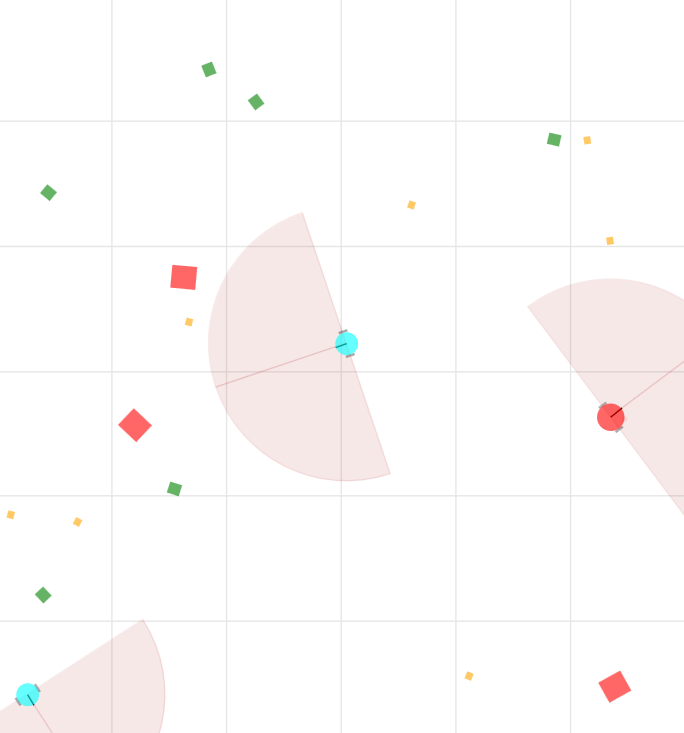

In [67]:
controller.stop()
stop_server_and_interface(safe_mode=False)

your 131072x1 screen size is bogus. expect trouble
 Found the process scripts/run_interface.py running with this PID: 11745
your 131072x1 screen size is bogus. expect trouble
 Found the process scripts/run_server.py running with this PID: 11573
Killed process with PID: 11745
Killed process with PID: 11573

Server and Interface processes have been stopped




Stopping server and interface processes

Received signal 15, shutting down


False